# Time Causal VAE

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import yaml
sys.path.append('../src')
sys.path.append('../../../..')
from tsvae.utils.logger_utils import get_console_logger
logger = get_console_logger(__name__)
from os import path as pt
from data_processing.post_processing import post_processing
from data_processing.config import post_processing_config
from models.DeepHedger import hedging

## Data used in original paper

(2516, 2)


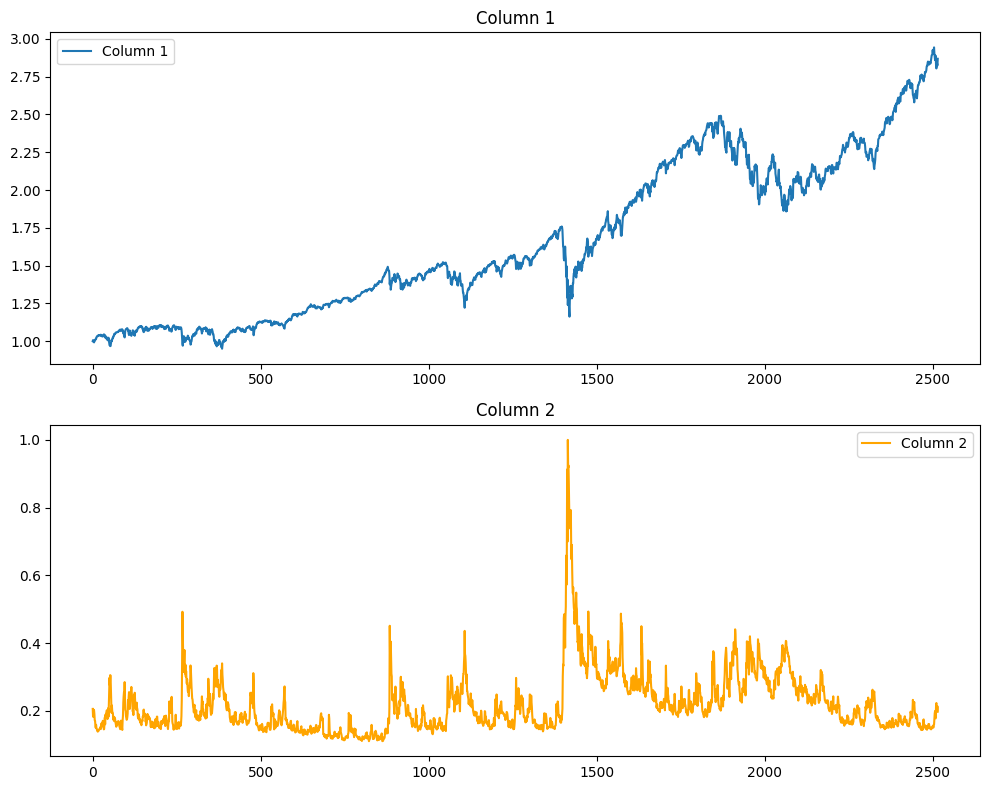

In [2]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load("../data/sp500vix/sp500vix_normalized.npy")
print(data.shape)
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

axs[0].plot(data[:, 0], label="Column 1")
axs[0].set_title("Column 1")
axs[0].legend()

axs[1].plot(data[:, 1], label="Column 2", color="orange")
axs[1].set_title("Column 2")
axs[1].legend()

plt.tight_layout()
plt.show()


## Create Data for Master Thesis

In [4]:
import numpy as np
import pandas as pd

df = pd.read_csv("../../../../../data/raw/spy_daily_closing_prices_train.csv", index_col = 0)
# df["vol"] = df["Close"].rolling(window=30).std()
# df = df.dropna()
price_scaler = data[0, 0]
vol_scaler = np.max(data[:, 1])
data = df.to_numpy()
data[:, 0] = data[:, 0]/price_scaler
data[:, 1] = data[:, 1]/vol_scaler
print(data.shape)
np.save("../data/sp500vix/sp500_normalized.npy", data)



(1089, 2)


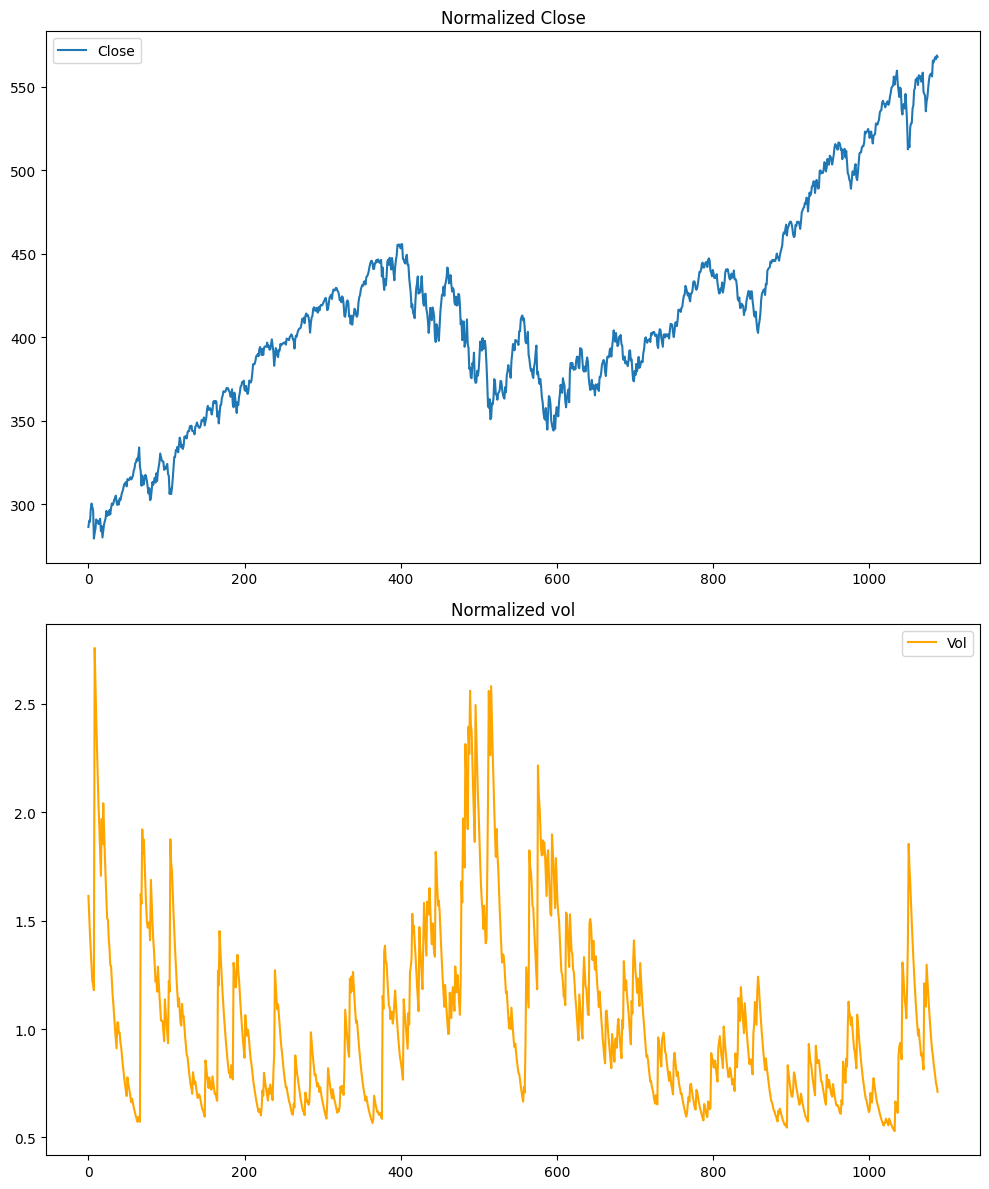

In [5]:
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

axs[0].plot(data[:, 0], label="Close")
axs[0].set_title("Normalized Close")
axs[0].legend()

axs[1].plot(data[:, 1], label="Vol", color="orange")
axs[1].set_title("Normalized vol")
axs[1].legend()

# axs[2].plot(rolling_volatility, label="30-Day Rolling Volatility", color="green")
# axs[2].set_title("30-Day Rolling Volatility of Column 1")
# axs[2].legend()

plt.tight_layout()
plt.show()

## TCVAE Model

In [6]:
from experiments.experiment_utils import get_output_dir, update_config
from tsvae.dataset.data_pipeline import DataPipeline
from tsvae.models.network_pipeline import NetworkPipeline
from tsvae.utils.random_utils import set_seed


base_output_dir = '..' 
new_config = {'epochs' : 100, 'wandb': False, 'comment': 'test'}
exp_config_path = '../configs/Master/betacvae.yaml'

with open(exp_config_path) as file:
    exp_config = dict(yaml.safe_load(file))

exp_config = update_config(exp_config, new_config)

exp_config.base_output_dir = base_output_dir
exp_config.output_dir = get_output_dir(exp_config)
logger.info(f"Experiment results saved to {exp_config.output_dir}")

logger.info(f"Saving experiment config to {exp_config.output_dir}")
config_file_path = pt.join(exp_config.output_dir, "exp_config.yaml")
with open(config_file_path, "w") as outfile:
    yaml.dump(exp_config, outfile, default_flow_style=False)
# logger.info(exp_config)

# Generating data
logger.info(f"Setting ramdom seed: {exp_config.seed}")
set_seed(exp_config.seed)

Experiment results saved to ../results/Master_timestep_30/model_BetaCVAE_De_CLSTMRes_En_CLSTMRes_Prior_RealNVP_Con_Id_Dis_None_comment_test
Saving experiment config to ../results/Master_timestep_30/model_BetaCVAE_De_CLSTMRes_En_CLSTMRes_Prior_RealNVP_Con_Id_Dis_None_comment_test
Setting ramdom seed: 0


In [7]:
logger.info(f"Loading dataset: {exp_config.dataset}")
data_pipeline = DataPipeline()
train_dataset, eval_dataset = data_pipeline(exp_config)

# Loading network
logger.info("Load networks:")
network_pipeline = NetworkPipeline()
model = network_pipeline(exp_config)
# logger.info(f"{model}")

Loading dataset: Master
Base dataset initialized
Load networks:


In [8]:
from tsvae.trainers.base_trainer_config import BaseTrainerConfig
from tsvae.trainers.training_pipeline import TrainingPipeline


training_config = BaseTrainerConfig(
    output_dir=exp_config.output_dir,
    learning_rate=exp_config.lr,
    per_device_train_batch_size=exp_config.train_batch_size,
    per_device_eval_batch_size=exp_config.eval_batch_size,
    optimizer_cls=exp_config.optimizer,
    optimizer_params=None,
    scheduler_cls=None,
    scheduler_params=None,
    steps_saving=exp_config.steps_saving,
    steps_predict=exp_config.steps_predict,
    seed=exp_config.seed,
    num_epochs=exp_config.epochs,
    wandb_callback=exp_config.wandb,
    wandb_output_dir=exp_config.base_output_dir + "/wandb",
)

train_pipeline = TrainingPipeline(model=model, training_config=training_config, exp_config=exp_config)

trainer = train_pipeline(
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    device_name=exp_config.device_name,
)

Path Visualization of data
Model passed sanity check !
Ready for training.



In [9]:
train_pipeline.train(log_output=True)

Created ../results/Master_timestep_30/model_BetaCVAE_De_CLSTMRes_En_CLSTMRes_Prior_RealNVP_Con_Id_Dis_None_comment_test/BetaCVAE_training_2025-04-21_22-10-04. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 100
 - per_device_train_batch_size: 256
 - per_device_eval_batch_size: 256
 - checkpoint saving every: 30
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.0005
    maximize: False
    weight_decay: 0
)
Scheduler: None
Device: cpu

Successfully launched training !

Training of epoch 1/100:  40%|████      | 2/5 [00:00<00:00, 16.89batch/s]total loss: 11.87
recon: 11.87
reg: -0.20
Eval of epoch 1/100:  20%|██        | 1/5 [00:00<00:00,  5.00batch/s]
--------------------------------------------------------------------------
Train loss: 13.0419
------------------------------------------------------------

In [11]:
from evaluations.hyperparameter import ModelEvaluator
from os import path as pt

model_dir = pt.join(trainer.training_dir, 'final_model')
model_evaluator = ModelEvaluator(model_dir)
output_dir = model_evaluator.hyper_model_dir
model = model_evaluator.model

# test_data, gen_data, recon_data = model_evaluator.load_data(seed = 99, n_sample_test=1000)
# ds = model_evaluator.data_ppl.base_dataset

# real_data = test_data
# recon_data = recon_data
# fake_data = gen_data


df_tot_fake = pd.DataFrame()
# 100 times 1000 corresponds to M = 100.000
print("Generating data")
for i in range(100):
    test_data, gen_data, recon_data = model_evaluator.load_data(seed = i, n_sample_test=1000)
    ds = model_evaluator.data_ppl.base_dataset

    real_data = test_data
    recon_data = recon_data
    fake_data = gen_data

    df_sub_fake = pd.DataFrame(gen_data.detach().squeeze(-1).numpy())
    df_tot_fake = pd.concat([df_tot_fake, df_sub_fake], axis=0)

Base dataset initialized


Generating data


In [16]:
df_tot_fake = df_tot_fake.reset_index(drop=True)

In [17]:
post_processing(df_tot_fake, **post_processing_config)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1.0,0.984868,1.029781,1.030266,1.042778,1.032857,1.044121,1.051286,1.023747,1.028191,...,1.006719,1.022020,1.029147,1.013751,1.032881,1.061756,1.065923,1.073013,1.031581,1.062181
1,1.0,0.997909,1.055104,1.071557,1.083320,1.076626,1.082810,1.085221,1.074173,1.038621,...,1.108931,1.086376,1.094618,1.084399,1.100013,1.088019,1.082327,1.107424,1.091949,1.113530
2,1.0,1.095351,1.110535,1.165832,1.139913,1.120119,1.111240,1.119868,1.126356,1.138067,...,1.123891,1.146624,1.145669,1.120105,1.141097,1.147666,1.150261,1.147269,1.152490,1.122689
3,1.0,1.051372,1.053897,1.036096,0.976927,1.010060,1.039101,1.041332,1.049760,1.049837,...,1.059066,1.059840,1.065648,1.059078,1.050511,1.041852,1.071390,1.064552,1.061975,1.078738
4,1.0,1.028840,1.025132,0.988547,0.990006,0.987219,0.987619,0.989368,0.992810,1.017445,...,1.028281,1.030091,1.006227,0.996581,1.025963,1.013352,1.020783,1.025663,0.988869,1.021803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,1.0,0.919828,0.937780,0.939412,0.934527,0.972571,0.946408,0.935910,0.930641,0.891724,...,0.934814,0.928242,0.922821,0.926483,0.935345,0.922103,0.915175,0.951807,0.928726,0.931376
99996,1.0,0.962570,0.978323,0.954307,0.951930,0.973598,0.960701,0.956385,0.964195,0.974869,...,0.965340,0.959919,0.932336,0.961764,0.958476,0.956056,0.948035,0.925999,0.922131,0.937422
99997,1.0,0.945291,0.965012,0.961678,0.945638,0.959428,0.964067,0.967018,0.964665,0.969866,...,0.950641,0.938215,0.949423,0.951553,0.953365,0.937489,0.940216,0.930404,0.959053,0.951318
99998,1.0,0.944266,0.917581,0.926360,0.945223,0.936725,0.944013,0.934411,0.936435,0.947318,...,0.945279,0.946202,0.934029,0.919665,0.913899,0.901401,0.938626,0.923292,0.926660,0.944936


## Real Data (l) and Fake Data (r)

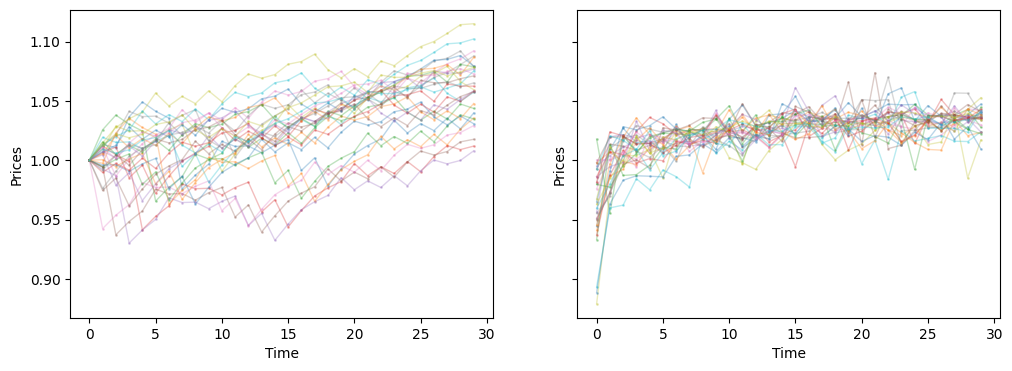

In [63]:
from evaluations.compare import compare_path
compare_path(real_data,fake_data, plot_size=30)

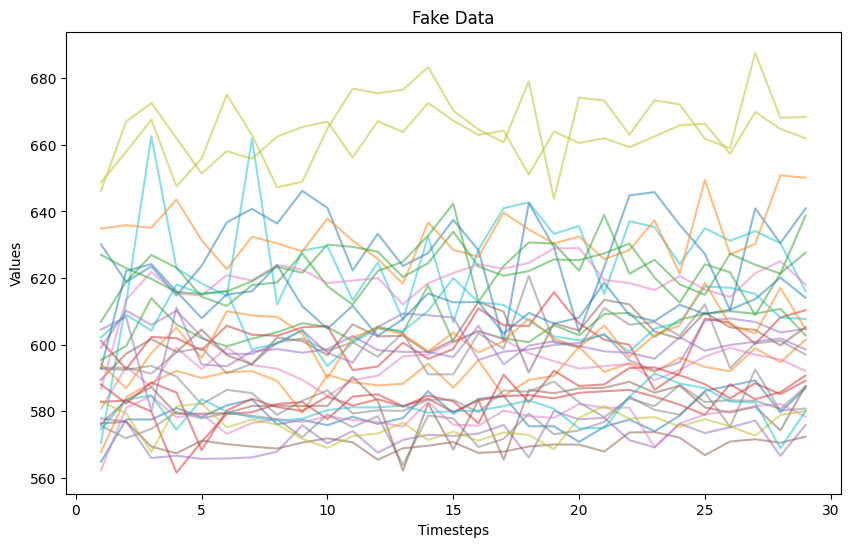

In [76]:
sys.path.append('../../../..')
from data_processing.post_processing import post_processing
from data_processing.config import post_processing_config

df_post_processed = post_processing(pd.DataFrame(fake_data.detach().squeeze(-1).numpy()), **post_processing_config)

diff = df_post_processed.iloc[:, [0]] - 500
diff = pd.DataFrame(np.tile(diff.values, (1, 30)))

df_post_processed = df_post_processed - diff

fig, ax = plt.subplots(figsize=(10, 6))

for i in range(30):  # Iterate over samples
    ax.plot(df_post_processed.iloc[i, :], alpha=0.5)  # Plot each sample

ax.set_title("Fake Data")
ax.set_xlabel("Timesteps")
ax.set_ylabel("Values")
plt.show()

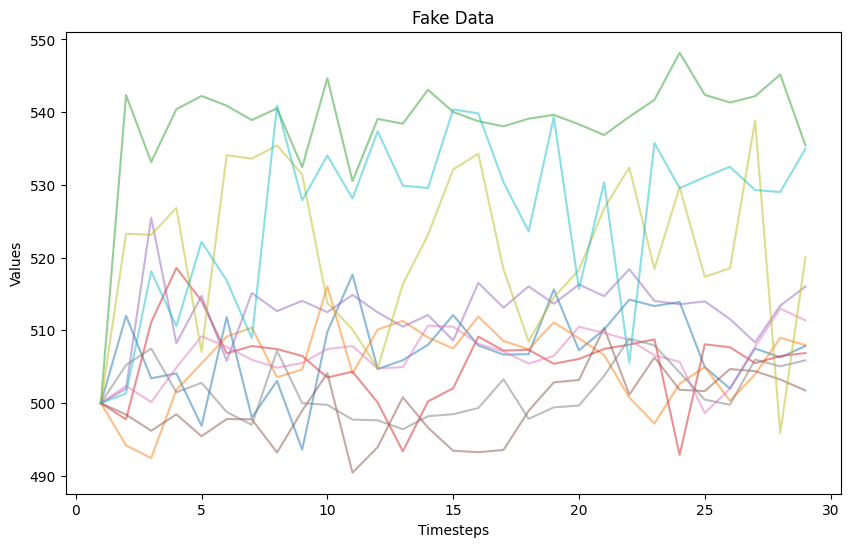

In [53]:
df_post_processed_norm = df_post_processed - diff

fig, ax = plt.subplots(figsize=(10, 6))

for i in range(10):  # Iterate over samples
    ax.plot(df_post_processed_norm.loc[i, :], alpha=0.5)  # Plot each sample

ax.set_title("Fake Data")
ax.set_xlabel("Timesteps")
ax.set_ylabel("Values")
plt.show()

In [52]:
df_post_processed.to_csv("../../../../../data/processed/tc_vae_synth_data.csv")